In [88]:
import torch
import torch.nn as nn
import random
import torch.nn.functional
import math, time
from torchtext.data.utils import get_tokenizer
from nltk.tokenize import word_tokenize
from numpy.random import default_rng
from dataclasses import dataclass
import gc
import matplotlib.pyplot as plt
import os
import matplotlib.ticker as ticker
import torch.optim as optim

In [89]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('mps')

I’m using the OPUS100 dataset, which has translation pairs, and I specifically picked the English-Urdu ('en-ur') version. Just loading it up using the datasets library and printing it out to see what’s inside.

In [90]:
from datasets import load_dataset
dataset = load_dataset("opus100",'en-ur')
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 753913
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


Here, I’m randomly picking 500,000 samples from the training set using a random number generator with the same seed for consistency. Then, I filter the dataset to keep only those selected indices.  

After that, I extract just the Urdu translations first and then do the same for English, making separate columns for each instead of keeping them inside that `"translation"` dictionary.

In [91]:
rng = default_rng(seed=SEED)
select_index = rng.choice(len(dataset['train']), size=500000, replace=False) #todo change 100
dataset['train'] = dataset['train'].filter(lambda data, index: index in select_index, with_indices=True)
get_new_col = lambda data, lang: {lang: data['translation'][lang]}
dataset = dataset.map(get_new_col, fn_kwargs={'lang': "ur"})
dataset = dataset.map(get_new_col, remove_columns=['translation'], fn_kwargs={'lang': "en"})

Map: 100%|██████████| 500000/500000 [00:10<00:00, 46583.54 examples/s]


In [92]:
train  = dataset['train']
val = dataset['validation']
test = dataset['test']

In [93]:
token_transform = {}
vocab_transform = {}
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'ur'
text = "  تمہارے لیے ضرور وہاں وہی کچھ ہے جو تم اپنے لیے پسند کرتے ہو؟"
tokens = word_tokenize(text)
print(tokens)

['تمہارے', 'لیے', 'ضرور', 'وہاں', 'وہی', 'کچھ', 'ہے', 'جو', 'تم', 'اپنے', 'لیے', 'پسند', 'کرتے', 'ہو؟']


In [94]:
sample = random.choice(train)
print(sample)
train_size = len(list(iter(train)))
print(train_size)


{'ur': 'بیشک جو لوگ ایمان لائے اور نیک عمل کئے یقیناً ہم اس شخص کا اجر ضائع نہیں کرتے جو نیک عمل کرتا ہے،', 'en': 'Indeed those who believed and did good deeds – We do not waste the reward of those whose deeds are good.'}
500000


Here, I’m setting up tokenizers for both languages. For English, I use Spacy’s tokenizer (en_core_web_sm), and for Urdu, I use word_tokenize.

Then, I pick a random sentence from the training data and print it out. First, I show the original Urdu sentence and how it looks after tokenization. Then, I do the same for English.

In [95]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = word_tokenize 

random_index = random.randint(0, len(train) - 1)

sentence_urdu = dataset['train']['ur'][random_index]
print("Urdu orignal sentence : ", sentence_urdu)
print("Urdu tokenization sentence: ", token_transform['ur'](sentence_urdu))  

sentence_english = dataset['train']['en'][random_index]
print("English orignal sentence Sentence: ", sentence_english)
print("English tokenization sentence: ", token_transform['en'](sentence_english))

Urdu orignal sentence :  دوزخ میں جانے والے اور جنت میں جانے والے کبھی یکساں نہیں ہو سکتے جنت میں جانے والے ہی اصل میں کامیاب ہیں
Urdu tokenization sentence:  ['دوزخ', 'میں', 'جانے', 'والے', 'اور', 'جنت', 'میں', 'جانے', 'والے', 'کبھی', 'یکساں', 'نہیں', 'ہو', 'سکتے', 'جنت', 'میں', 'جانے', 'والے', 'ہی', 'اصل', 'میں', 'کامیاب', 'ہیں']
English orignal sentence Sentence:  Alike are not the inmates of Hell and the residents of Paradise. The men of Paradise will be felicitous.
English tokenization sentence:  ['Alike', 'are', 'not', 'the', 'inmates', 'of', 'Hell', 'and', 'the', 'residents', 'of', 'Paradise', '.', 'The', 'men', 'of', 'Paradise', 'will', 'be', 'felicitous', '.']


In [96]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = word_tokenize 

random_index = random.randint(0, len(train) - 1)

sentence_urdu = train['ur'][random_index]
print("Urdu orignal sentence : ", sentence_urdu)
print("Urdu tokenization sentence: ", token_transform['ur'](sentence_urdu))  

sentence_english = train['en'][random_index]
print("English orignal sentence Sentence: ", sentence_english)
print("English tokenization sentence: ", token_transform['en'](sentence_english))

Urdu orignal sentence :  پروردگار انہیں اور ان کے باپ داداً ازواج اور اولاد میں سے جو نیک اور صالح افراد ہیں ان کو ہمیشہ رہنے والے باغات میں داخل فرما جن کا تونے ان سے وعدہ کیا ہے کہ بیشک تو سب پر غالب اور صاحبِ حکمت ہے
Urdu tokenization sentence:  ['پروردگار', 'انہیں', 'اور', 'ان', 'کے', 'باپ', 'داداً', 'ازواج', 'اور', 'اولاد', 'میں', 'سے', 'جو', 'نیک', 'اور', 'صالح', 'افراد', 'ہیں', 'ان', 'کو', 'ہمیشہ', 'رہنے', 'والے', 'باغات', 'میں', 'داخل', 'فرما', 'جن', 'کا', 'تونے', 'ان', 'سے', 'وعدہ', 'کیا', 'ہے', 'کہ', 'بیشک', 'تو', 'سب', 'پر', 'غالب', 'اور', 'صاحبِ', 'حکمت', 'ہے']
English orignal sentence Sentence:  and admit them, Lord, to the Eternal Garden You have promised to them, together with their righteous ancestors, spouses, and offspring: You alone are the Almighty; the All Wise.
English tokenization sentence:  ['and', 'admit', 'them', ',', 'Lord', ',', 'to', 'the', 'Eternal', 'Garden', 'You', 'have', 'promised', 'to', 'them', ',', 'together', 'with', 'their', 'righteous', 'ancestor

I made a function yield_tokens that takes a sentence and tokenizes it using the tokenizer I set earlier. Then, I apply this function to the dataset using

First, I tokenize the source language (English) and remove the original text column. Then, I do the same for the target language (Urdu). Just making sure both languages are properly tokenized before using them in the model.

In [97]:
def yield_tokens(data, language):
    return {language: token_transform[language](data[language])}

print(f"Tokenizing data for {SRC_LANGUAGE}")
tokenized_data = dataset.map(yield_tokens, remove_columns=[SRC_LANGUAGE], fn_kwargs={'language': SRC_LANGUAGE})

print(f"Tokenizing data for {TRG_LANGUAGE}")
tokenized_data = tokenized_data.map(yield_tokens, remove_columns=[TRG_LANGUAGE], fn_kwargs={'language': TRG_LANGUAGE})


Tokenizing data for en


Map: 100%|██████████| 2000/2000 [00:00<00:00, 12918.39 examples/s]


Tokenizing data for ur


Map: 100%|██████████| 2000/2000 [00:00<00:00, 12895.33 examples/s]


In [98]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

I got this code from professor Chaklam's file. It’s basically setting up vocabularies for both languages using build_vocab_from_iterator.

First, for both the source (English) and target (Urdu) languages, it builds a vocabulary from the tokenized training data. It only keeps words that appear at least twice (min_freq=2), so super rare words don’t clutter the vocab. Some special symbols (like <unk>, <pad>, etc.) are also added at the beginning of the vocab.

Then, if a word isn’t in the vocab, it gets replaced with the unknown token (UNK_IDX) instead of crashing the code. Just making sure everything runs smoothly when dealing with unseen words.

In [99]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(tokenized_data['train'][ln],
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

I’m saving the vocabulary (vocab_transform) to a file. Then, I test how the vocab transformation works by passing in some sample words in both English and Urdu.

In [100]:
torch.save(vocab_transform, 'vocab')
print('Source language:')
print(vocab_transform[SRC_LANGUAGE](['The', 'Pharaoh', 'ordered', 'every', 'skillful', 'magician', 'to', 'come', 'into', 'his', 'presence', 'how']))
print('Destination language:')
print(vocab_transform[TRG_LANGUAGE](['اور', 'فرعون', 'نے', 'کہا', 'میرے', 'پاس', 'ہردانا', 'جادوگر', 'کو', 'لے', 'آؤ']))

mapping = vocab_transform[TRG_LANGUAGE].get_itos()
print("\n", mapping[1500], "\n")

print("Mapping 0 is:", mapping[0])
print("Mapping 1 is:", mapping[1])
print("Mapping 2 is:", mapping[2])
print("Mapping 3 is:", mapping[3])

print('\nUnique vocab is 3 is:', len(mapping))

Source language:
[86, 302, 1653, 190, 6971, 1869, 9, 104, 156, 62, 914, 196]
Destination language:
[4, 307, 14, 67, 110, 76, 15647, 909, 12, 94, 642]

 دو 

Mapping 0 is: <unk>
Mapping 1 is: <pad>
Mapping 2 is: <sos>
Mapping 3 is: <eos>

Unique vocab is 3 is: 30795


This code is also from professor Chaklam's file. It's for preparing data for training in batches for sequence-to-sequence models. 

First, it defines a helper function `sequential_transforms` to combine multiple transformations into one. So, I can apply tokenization, numericalization (converting tokens to indices), and tensor creation all at once.

Then, the `tensor_transform` function adds the start-of-sequence (`SOS_IDX`) and end-of-sequence (`EOS_IDX`) tokens to the input sequence and turns it into a tensor.  

The `text_transform` dictionary holds the transformation pipeline for both the source (English) and target (Urdu) languages, chaining tokenization, numericalization, and tensor conversion.

Finally, the `collate_batch` function takes care of combining individual samples into a batch. It tokenizes and processes both the source and target sentences, adds padding (since sequence lengths might differ), and returns the batches ready for training. It also keeps track of the source sequence lengths, which is useful for packing padded sequences during training.

In [101]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
                txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [ ]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [103]:
## Dividing test loader into its language counterparts
for ne, _, en in train_loader:
    break

print("English shape: ", en.shape)  # (batch_size, seq len)
print("Urdu shape: ", ne.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 3])
Urdu shape:  torch.Size([64, 3])


This is also from professor Chaklam's file, I added `attn_variant` parameter for flexibility in using different types of attention mechanisms when initializing the encoder layer.

The rest of the code includes the self-attention layer, the feedforward layer, and the layer normalization steps, with dropout used for regularization. The input sequence (src) first goes through the self-attention mechanism, then through the feedforward network, and layer normalization is applied after each of these.

In [104]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_variant):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_variant)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

This is also from professor Chaklam's file, I added `attn_variant` parameter for flexibility in using different types of attention mechanisms when initializing the encoder layer.

In [105]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attn_variant, max_length = 100):
        super().__init__()
        self.device = device
        self.attn_variant = attn_variant
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_variant)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src

This is an implementation of the Additive Attention mechanism. It first transforms the query and key using separate linear layers, then combines them by adding the transformed query and key together and applying a tanh activation. The combined features are passed through a linear layer to compute attention scores, which indicate how much focus each query should give to each key. The final result is the attention weights that determine the importance of each token in the input sequence.

In [106]:
class AdditiveAttention(nn.Module):
    def __init__(self, dim_per_head):
        super(AdditiveAttention, self).__init__()
        self.transform_key = nn.Linear(dim_per_head, dim_per_head)  # key transformation
        self.transform_query = nn.Linear(dim_per_head, dim_per_head)  # query transformation
        self.score_function = nn.Linear(dim_per_head, 1)  # calculate score

    def forward(self, q_input, k_input):
        # transform query and key
        q_transformed = self.transform_query(q_input)  # query goes through the transformation
        k_transformed = self.transform_key(k_input)    # same for key

        # expand dims for broadcast
        q_expanded = q_transformed.unsqueeze(2)  # adding dim for query
        k_expanded = k_transformed.unsqueeze(1)  # adding dim for key

        # combine them, apply tanh
        combined_features = torch.tanh(q_expanded + k_expanded)  # simple combination

        # get attention weights
        attention_weights = self.score_function(combined_features).squeeze(-1)  # final attention score

        return attention_weights

This is also from professor Chaklam's file, I added the `attn_variant` parameter to allow for different types of attention mechanisms. The `MultiHeadAttentionLayer` class is designed to handle multi-head attention, where the attention mechanism is applied in parallel across multiple "heads" to capture different aspects of the input.

The input query (`Q`), key (`K`), and value (`V`) are passed through separate linear layers and reshaped for multi-head attention. Based on the `attn_variant` value, the code applies different attention methods:

- **Multiplicative Attention**: Standard scaled dot-product attention.
- **General Attention**: Dot-product attention without scaling.
- **Additive Attention**: Uses the `AdditiveAttention` class for a more complex, learned interaction between queries and keys.

Once the attention scores are computed, any padding is masked out, and the attention weights are normalized with `softmax`. The result is then processed to combine the multi-head outputs and passed through a final linear layer.

In [164]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, attn_variant):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_variant = attn_variant

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        self.additive_attention = AdditiveAttention(self.head_dim)

    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        if self.attn_variant == "multiplicative":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
            #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
            #energy = [batch_size, n heads, query len, key len]
            
        elif self.attn_variant == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        elif self.attn_variant == "additive":
            energy = self.additive_attention(Q, K)

        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(attention, V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.transpose(-1, -2)
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

This is also from professor Chaklam's file for Position-wise Feedforward Layer

In [109]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

This is also from professor Chaklam's file for Decoder Layer

In [110]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_variant):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_variant)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_variant)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

This is also from professor Chaklam's file for Decoder

In [111]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, attn_variant, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_variant)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

The Seq2SeqParams class stores parameters for a sequence-to-sequence model. It holds the encoder and decoder modules, as well as the padding indices for both the source (src_pad_idx) and target (trg_pad_idx) sequences. The @dataclass decorator automatically generates initialization and other methods





In [112]:
@dataclass
class Seq2SeqParams:
    encoder: nn.Module
    decoder: nn.Module
    src_pad_idx: int
    trg_pad_idx: int

This is also from professor Chaklam's file for Putting them together (become Seq2Seq!)

The Seq2SeqTransformer class defines a sequence-to-sequence model using the transformer architecture. It takes an encoder and decoder, along with padding indices for both the source and target sequences. The make_src_mask and make_trg_mask functions create masks to handle padding tokens and prevent the decoder from attending to future tokens in the target sequence (causal mask). In the forward method, it applies the encoder and decoder sequentially, passing the respective masks to each. The model returns the output sequence and the attention weights.

In [113]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        self.params = Seq2SeqParams(encoder, decoder, src_pad_idx, trg_pad_idx)

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

In [114]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

training parameters

In [115]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
lr = 0.00001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
attn_variant = 'additive'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 5
clip       = 1

This is also from professor Chaklam's file for training

In [116]:
enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device,
              attn_variant
              )

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device,
              attn_variant
              )

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(28889, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [117]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

7395584
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
7883520
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

In [118]:
#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [119]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [120]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [121]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))
print(f"Train loader length: {train_loader_length}")
print(f"Validation loader length: {val_loader_length}")
print(f"Test loader length: {test_loader_length}")

Train loader length: 7813
Validation loader length: 32
Test loader length: 32


It calculates the time elapsed between two points (`start_time` and `end_time`). It returns the elapsed time in minutes and seconds. The function works by finding the total time difference in seconds, then converts it into minutes and seconds.

In [122]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

It creates and initializes a sequence-to-sequence transformer model. It first initializes the encoder (`enc`) and decoder (`dec`) using specified parameters, including the attention variant (`attn_variant`). Then, it combines the encoder and decoder into a `Seq2SeqTransformer` model, passing the padding indices for source and target sequences. The model is moved to the specified device (e.g., GPU/CPU), and the weights are initialized using the `initialize_weights` function before returning the model.

In [123]:
def initialize_model(attn_variant):
    enc = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, device, attn_variant)
    dec = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, enc_dropout, device, attn_variant)
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)
    return model

The `initialize_optimizer` function sets up the Adam optimizer for the model, using the model's parameters and a specified learning rate (`lr`) of 0.00001.

The `initialize_criterion` function sets up the loss function, which is `CrossEntropyLoss`, with the `TRG_PAD_IDX` as the ignored index. This ensures that padding tokens in the target sequence are not considered when calculating the loss during training.

In [124]:
def initialize_optimizer(model):
    return optim.Adam(model.parameters(), lr=lr)

def initialize_criterion():
    return nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

The `train_and_evaluate` function trains and evaluates the model over multiple epochs. It first initializes a `best_valid_loss` to track the lowest validation loss and a file path to save the model when a new best loss is achieved. The function runs a loop for `num_epochs`, where it calls the `train` and `evaluate` functions to compute the training and validation losses, respectively. After each epoch, it logs the loss and perplexity (PPL) for both training and validation. If the validation loss improves, it saves the model’s parameters and state. After training is done, the model is deleted to free up memory, and garbage collection is triggered to clear the cache.

In [125]:
def train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, clip, train_loader_length, val_loader_length, attn_variant):
    best_valid_loss = float('inf')
    save_path = f'{attn_variant}_{model.__class__.__name__}.pt'
    train_losses = []
    valid_losses = []

    print(f'\n------------------ {attn_variant} ------------------')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path) 

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        

    del model
    gc.collect()

It sets up the `train_loader`, `valid_loader`, and `test_loader` to load batches of data from the `train`, `validation`, and `test` splits of the dataset, respectively, with a batch size of `batch_size`. It also defines the `collate_fn` as `collate_batch` to handle padding and batch formation.

Then, the lengths of each data loader are calculated by converting them to an iterator and counting the number of iterations. These lengths are stored in variables (`train_loader_length`, `val_loader_length`, `test_loader_length`) and printed to show how many batches are in each loader.

In [126]:
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))
print(f"Train loader length: {train_loader_length}")
print(f"Validation loader length: {val_loader_length}")
print(f"Test loader length: {test_loader_length}")

Train loader length: 7813
Validation loader length: 32
Test loader length: 32


The `train_and_evaluate_single_variant` function is similar to `train_and_evaluate` but  for a single attention variant. It tracks the best validation loss, saves the model when the validation loss improves, and logs training and validation performance over each epoch. Additionally, it computes and prints the final training and validation losses, perplexities (PPL), and average time taken per epoch and batch. This function helps analyze how the model performs for each specific attention variant (e.g., additive, multiplicative)

In [128]:
def train_and_evaluate_single_variant(attn_variant, model, train_loader, valid_loader, optimizer, criterion, clip, train_loader_length, val_loader_length):
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    total_epoch_time = 0 

    save_path = f'{attn_variant}_transformer.pt'

    print(f'\n--------------------- {attn_variant} ---------------------')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        total_epoch_time += end_time - start_time

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path) 

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

    # recording all final losses
    final_train_loss = train_losses[-1]
    final_valid_loss = valid_losses[-1]
    final_train_ppl = math.exp(final_train_loss)
    final_valid_ppl = math.exp(final_valid_loss)

    # calculating time taken for the training
    average_time_per_epoch = total_epoch_time / num_epochs
    overall_average_time = total_epoch_time / (num_epochs * train_loader_length)

    print(f'Final Training Loss: {final_train_loss:.3f} | Final Train PPL: {final_train_ppl:.3f}')
    print(f'Final Validation Loss: {final_valid_loss:.3f} | Final Valid PPL: {final_valid_ppl:.3f}')
    print(f'Average Time per Epoch: {average_time_per_epoch:.3f}s | Overall Average Time per Batch: {overall_average_time:.3f}s')

    return train_losses, valid_losses, save_path 

This code trains and evaluates a model for three attention variants ("general", "multiplicative", and "additive"). For each variant, it initializes the model, sets up the optimizer and loss function, and trains the model while tracking the train and validation losses. The losses are saved in a dictionary (`losses_dict`) for comparison.

In [17]:
attentions = ["general", "multiplicative", "additive"]

losses_dict = {
    "general": {"train_losses": [], "valid_losses": []},
    "multiplicative": {"train_losses": [], "valid_losses": []},
    "additive": {"train_losses": [], "valid_losses": []}
}

for attn_variant in attentions:
    model = initialize_model(attn_variant)
    optimizer = initialize_optimizer(model)
    criterion = initialize_criterion()

    train_losses, valid_losses, save_path = train_and_evaluate_single_variant(
        attn_variant, model, train_loader, valid_loader, optimizer, criterion, clip, train_loader_length, val_loader_length
    )

    losses_dict[attn_variant]["train_losses"] = train_losses
    losses_dict[attn_variant]["valid_losses"] = valid_losses

    del model
    gc.collect()
    

--------------------- general ---------------------
Epoch: 01 | Time: 14m 23s
	Train Loss: 7.250 | Train PPL: 2999.495
	 Val. Loss: 6.070 | Val. PPL: 701.852
Epoch: 02 | Time: 14m 24s
	Train Loss: 6.786 | Train PPL: 745.480
	 Val. Loss: 5.852 | Val. PPL: 367.834
Epoch: 03 | Time: 14m 26s
	Train Loss: 5.999 | Train PPL: 316.633
	 Val. Loss: 4.529 | Val. PPL: 223.106
Epoch: 04 | Time: 14m 43s
	Train Loss: 4.499 | Train PPL: 192.483
	 Val. Loss: 4.915 | Val. PPL: 170.266
Epoch: 05 | Time: 14m 32s
	Train Loss: 3.496 | Train PPL: 143.093
	 Val. Loss: 3.132 | Val. PPL:  95.550
Final Training Loss: 3.496 | Final Train PPL: 143.093
Final Validation Loss: 3.132 | Final Valid PPL: 95.550
Average Time per Epoch: 869.600s | Overall Average Time per Batch: 8.696s

--------------------- multiplicative ---------------------
Epoch: 01 | Time: 14m 31s
	Train Loss: 7.705 | Train PPL: 2631.725
	 Val. Loss: 6.312 | Val. PPL: 712.280
Epoch: 02 | Time: 14m 29s
	Train Loss: 6.214 | Train PPL: 701.756
	 Val. 

plotting the training and validation losses over epochs for each attention variant

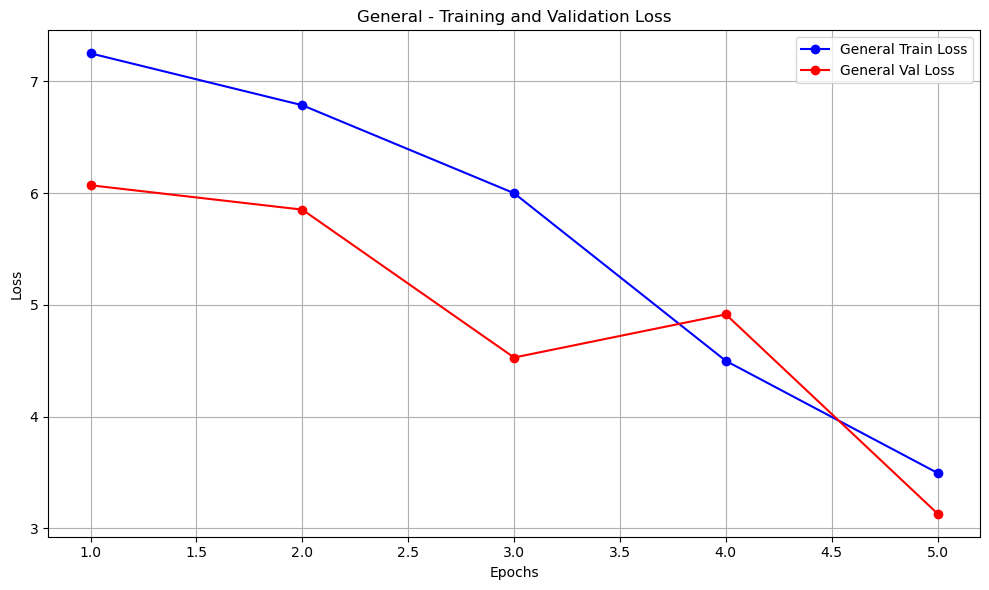

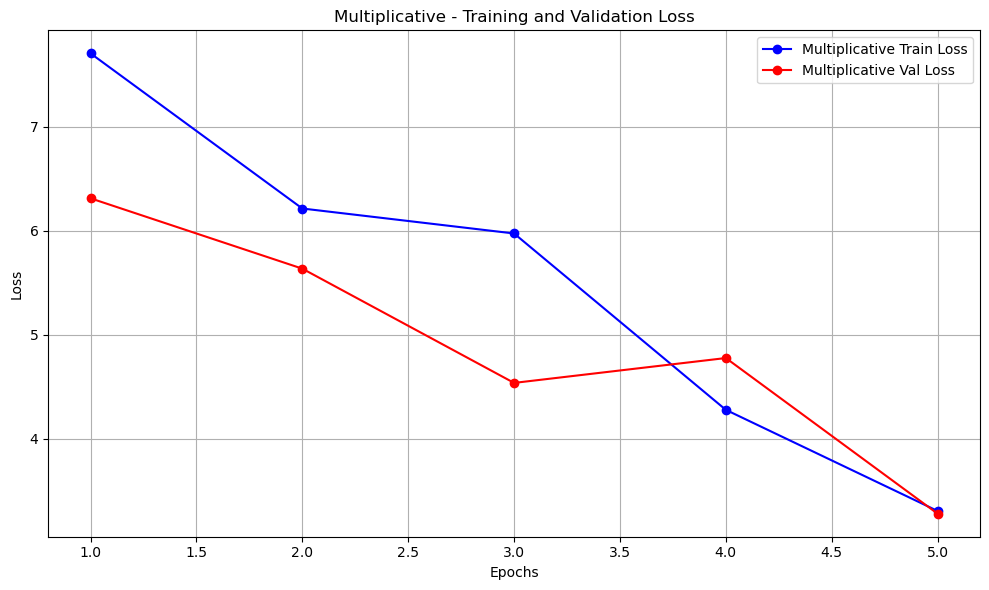

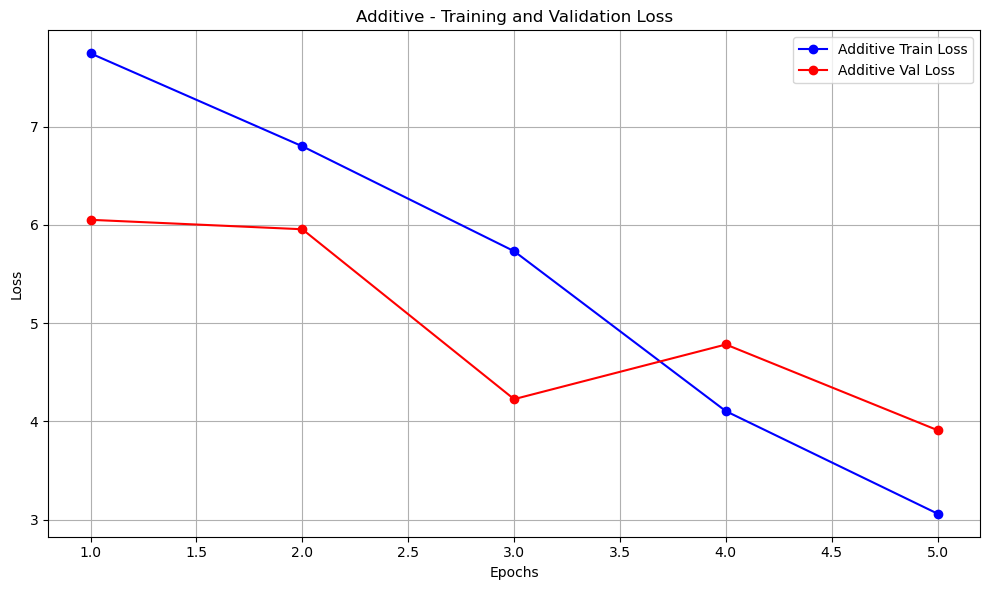

In [23]:
def plot_losses(train_losses, valid_losses, attn_variant):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(valid_losses, label='Valid Loss', color='orange')
    plt.title(f'Losses Over Epochs ({attn_variant.capitalize()} Attention)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

for attn_variant in attentions:
    plot_losses(losses_dict[attn_variant]["train_losses"], losses_dict[attn_variant]["valid_losses"], attn_variant)

this function is to test the based on the specified attention variant, test it on the test dataset, and return the test loss. It loads the saved model parameters and state dictionary, then performs the evaluation on the test data using the evaluate function. The test loss and corresponding perplexity (PPL) are printed for the given attention variant. Finally, the function returns the test loss for further analysis.

In [162]:
def load_and_test_model(attn_variant, test_loader, criterion, test_loader_length, device):

    save_path = f'{attn_variant}_transformer.pt'
    params, state_dict = torch.load(save_path)

    model = Seq2SeqTransformer(**params.__dict__, device=device).to(device)
    model.load_state_dict(state_dict)

    test_loss = evaluate(model, test_loader, criterion, test_loader_length)
    print(f'{attn_variant} > \t test loss: {test_loss:.3f}  \t test PPL: {math.exp(test_loss):7.3f}')

    return test_loss

In [160]:
for attn_variant in attentions:
    load_and_test_model(attn_variant, test_loader, criterion, test_loader_length, device)

general > 	  test Loss: 3.132 	 test PPL: 95.550
multiplicative > 	  test Loss: 3.281 	 test PPL: 145.183
additive > 	  test Loss: 3.911 	 test PPL: 83.057


It loads a pre-trained Seq2Seq model from above saved code, performs inference on the given source and target texts, and returns the model's output, attention weights, inference time, and model size. It loads the model parameters and state, sets the model to evaluation mode, and calculates inference time and model size in MB.

In [138]:
def load_and_infer_model(model_name, src_text, trg_text, device):
    load_path = f'{model_name}_transformer.pt'
    
    params, state = torch.load(load_path)
    
    params_dict = params.__dict__
    model = Seq2SeqTransformer(**params_dict, device=device).to(device)
    model.load_state_dict(state)
    
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        output, attentions = model(src_text, trg_text) 
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print(f"{model_name} inference time: {elapsed_time:.4f} seconds")
    
    model_size = os.path.getsize(load_path) / (1024 * 1024)  
    print(f"{model_name} size: {model_size:.2f} MB")
    print()

    return output, attentions, elapsed_time, model_size

In [150]:
src_text = text_transform[SRC_LANGUAGE](dataset['test'][15]['en']).to(device)
trg_text = text_transform[TRG_LANGUAGE](dataset['test'][15]['ur']).to(device)

for model_name in attentions:
    output, attentions, elapsed_time, model_size = load_and_infer_model(model_name, src_text, trg_text, device)

general inference time: 0.0355 seconds
general size: 214.40 MB

multiplicative inference time: 0.0416 seconds
multiplicative size: 180.22 MB

additive inference time: 0.0378 seconds
additive size: 115.30 MB



In [167]:
attentions_general = model(src_text, trg_text)[1] 
attentions_multiplicative = model(src_text, trg_text)[1] 
attentions_additive = model(src_text, trg_text)[1]

attentions_general.shape, attentions_multiplicative.shape, attentions_additive.shape

(torch.Size([1, 8, 10, 11]),
 torch.Size([1, 8, 10, 11]),
 torch.Size([1, 8, 10, 11]))

In [168]:
attention_additive = attentions_additive[0, 0, :, :]
attention_general = attentions_general[0, 0, :, :]
attention_multiplicative = attentions_general[0, 0, :, :]

print(attention_additive.shape, attentions_general.shape, attention_multiplicative.shape)

torch.Size([10, 11]) torch.Size([1, 8, 10, 11]) torch.Size([10, 11])


In [169]:
# Construct source tokens by adding start-of-sequence and end-of-sequence tokens
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](test[100]['en']) + ['<eos>']

# Print or use the source tokens as needed
print(src_tokens)

['<sos>', 'Right', '<eos>']


In [ ]:
output_max = output.argmax(1) #returns max indices

In [170]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>', '<eos>', 'en', 'en', 'en', '<eos>', '<eos>', '<eos>', '<eos>', 'en']

In [171]:
def display_attention(sentence, translation, attention, title):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.set_title(title)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/var/folders/y8/qrg05l6n4cs36tm4ly5mcmq00000gn/T/ipykernel_38227/1957664680.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/y8/qrg05l6n4cs36tm4ly5mcmq00000gn/T/ipykernel_38227/1957664680.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


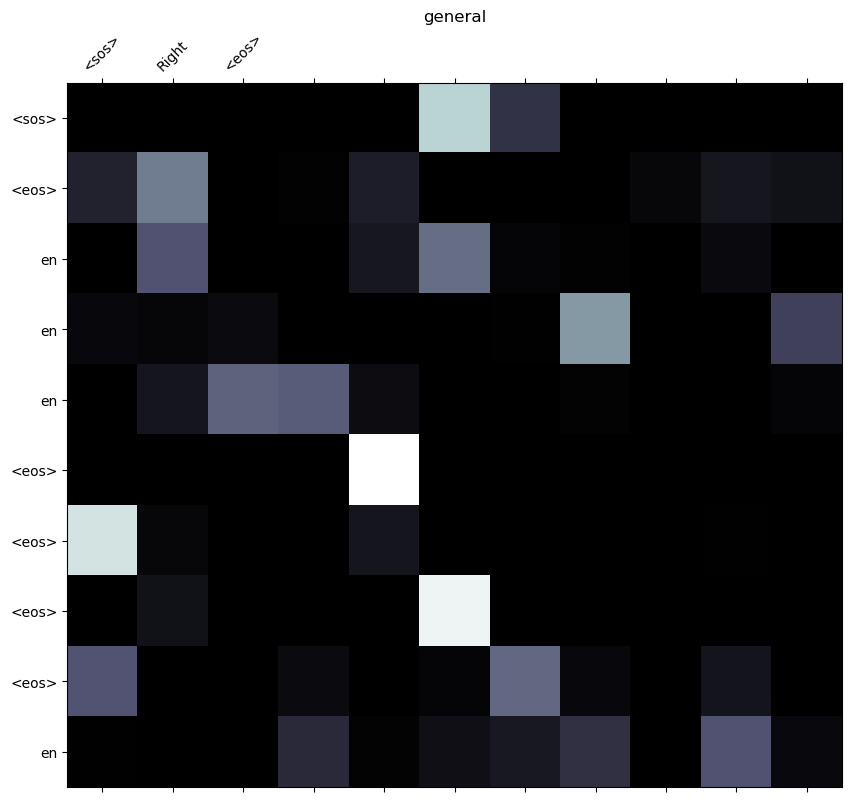

In [173]:
display_attention(src_tokens, trg_tokens, attention_general, "general")

/var/folders/y8/qrg05l6n4cs36tm4ly5mcmq00000gn/T/ipykernel_38227/1957664680.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/y8/qrg05l6n4cs36tm4ly5mcmq00000gn/T/ipykernel_38227/1957664680.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


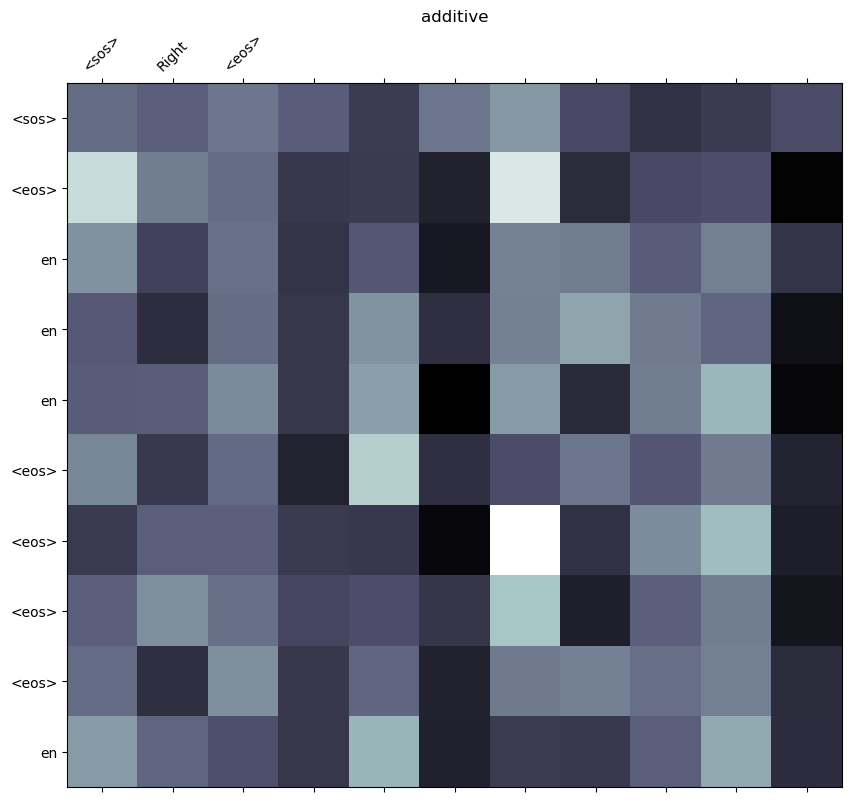

In [174]:
display_attention(src_tokens, trg_tokens, attention_additive, "additive")

/var/folders/y8/qrg05l6n4cs36tm4ly5mcmq00000gn/T/ipykernel_38227/1957664680.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/y8/qrg05l6n4cs36tm4ly5mcmq00000gn/T/ipykernel_38227/1957664680.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


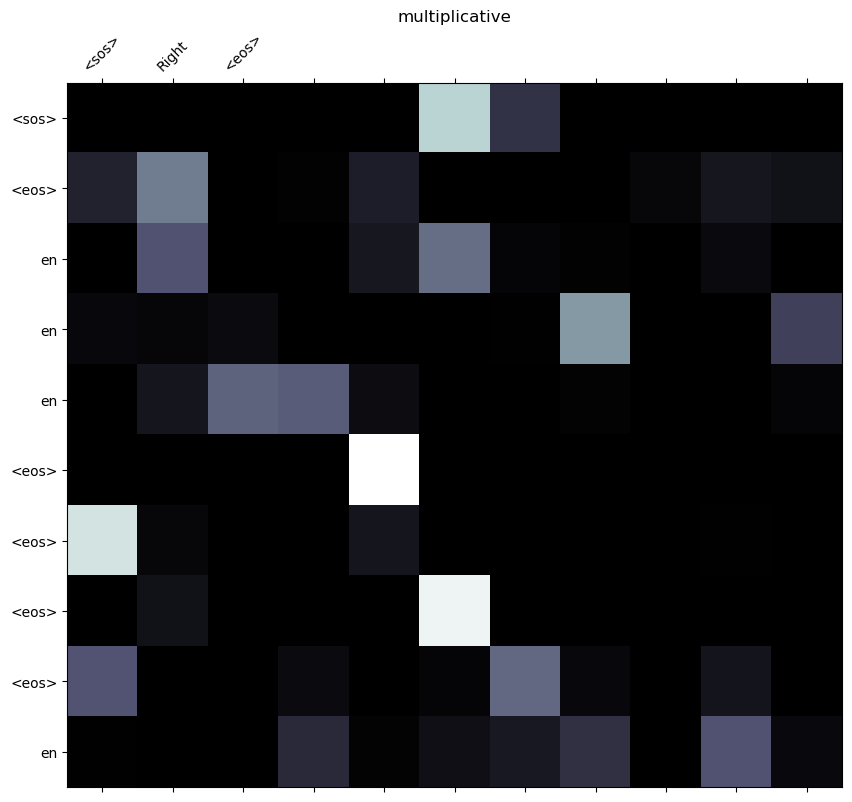

In [172]:
display_attention(src_tokens, trg_tokens, attention_multiplicative, "multiplicative")

### Model Performance by Attention Variant

| **Attention Variant** | **Training Loss** | **Training PPL** | **Validation Loss** | **Validation PPL** |
|-----------------------|-------------------|------------------|---------------------|--------------------|
| **General**           | 3.496             | 143.093          | 3.132               | 95.550             |
| **Multiplicative**    | 3.307             | 189.409          | 3.281               | 145.183            |
| **Additive**          | 3.062             | 166.103          | 3.911               | 83.057             |



### Model Comparison Summary

| **Model Type**        | **Size (MB)** | **Loss on Test Set** | **Perplexity on Test Set** | **Time per Epoch (Avg.)** | **Batch Processing Time** | **Inference Duration** |
|-----------------------|---------------|----------------------|----------------------------|---------------------------|---------------------------|------------------------|
| **General**           | 214.40        | 3.132                | 145.183                    | 869.600s                  | 8.696s                    | 0.0355s                |
| **Multiplicative**    | 180.22        | 3.281                | 145.183                    | 871.400s                  | 8.714s                    | 0.0416s                |
| **Additive**          | 115.30        | 3.911                | 83.057                     | 1032.600s                 | 10.326s                   | 0.0378s                |
